# Imports

In [1]:
import numpy as np
import dask.dataframe as dd
from tqdm import tqdm 
import pandas as pd
import matplotlib.pyplot as plt
import sys

import pickle

from sklearn.model_selection import train_test_split


import lightgbm as lgb

import string

from transformers import BertTokenizer

from sklearn.metrics import average_precision_score, log_loss

tokenizer = BertTokenizer.from_pretrained("twitter-tokenizer")

from dask.distributed import Client
client = Client()  # start distributed scheduler locally.  Launch dashboard
client

Client Scheduler: tcp://127.0.0.1:63373 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 31.82 GiB


# Functions

## Evalutation functions

In [2]:
def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

def compute_ap_lgb(pred, g):
    gt = np.array(g.get_label())
    pred = np.array(pred)
    ap = average_precision_score(gt, pred)
    return 'ap', ap, True


def compute_rce_lgb(pred, g):
    gt = np.array(g.get_label())
    pred = np.array(pred)
    rce = compute_rce(pred, gt)
    return 'rce',rce,True

def show_results(predictions, gt, model, train_columns):
    mean_predictions = np.mean(predictions)
    print("Mean of the predictions:", mean_predictions)
    print("Std of the predictions:", np.std(predictions))
    print("Histogram of the predictions:")
    plt.hist(predictions)
    plt.show()
    print("RCE:", compute_rce(predictions, gt.values))
    print("AP:", average_precision_score(gt, predictions))
    zipped = zip(train_columns, model.feature_importance('gain'))
    res = sorted(list(zipped), key = lambda x: x[1])
    print("Feature importance by 'gain':")
    plt.barh([tc for tc, gain in res], [gain for tc, gain in res])
    plt.show()
    
def evaluate_model(model, data, target, train_columns):
    predictions = model.predict(data[train_columns])
    show_results(predictions, data[target], model, train_columns)

## Features functions

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

basic_columns = ["tweet_type", "ratio_1", "ratio_2"]

vectorizer = TfidfVectorizer()


def basic_features(df):
    df["tweet_type"] = df["type"].apply(lambda x: 0 if x == "Retweet" else
                                        (1 if x == "Quote" else 2))
    df_text["ratio_1"] = df_text["AUTHOR_follower_count"] / df_text[
        "AUTHOR_following_count"]
    df_text["ratio_2"] = df_text["INTERACTOR_follower_count"] / df_text[
        "INTERACTOR_following_count"]
    return df


worst_words_retweet = [
    "game", "going", "haha", "lol", "but", "watching", "work", "home", "night",
    "bed", "well", "sleep", "gonna", "hey", "tomorrow", "tired", "some",
    "back", "bored", "listening"
]

best_words_retweet = [
    "you", "twitter", "please", "retweet", "post", "blog", "social", "free",
    "media", "help", "please retweet", "great", "social media", "10", "follow",
    "how to", "top", "blog post", "check out", "new blogpost"
]

common_english_words = [
    'the', 'at', 'and', 'a', 'to', 'in', 'is', 'you', 'that', 'it', 'he',
    'was', 'for', 'on', 'are', 'as', 'with', 'his', 'they', 'i', 'at', 'be',
    'this', 'have', 'from', 'or', 'one', 'had', 'by', 'word', 'but', 'not',
    'what', 'all', 'were', 'we', 'when', 'your', 'can', 'said', 'there', 'use',
    'an', 'each', 'which', 'she', 'do', 'how', 'their', 'if', 'will', 'up',
    'other', 'about', 'out', 'many', 'then', 'them', 'these', 'so', 'some',
    'her', 'would', 'make', 'like', 'him', 'into', 'time', 'has', 'look',
    'two', 'more', 'write', 'go', 'see', 'number', 'no', 'way', 'could',
    'people', 'my', 'than', 'first', 'water', 'been', 'call', 'who', 'oil',
    'its', 'now', 'find', 'long', 'down', 'day', 'did', 'get', 'come', 'made',
    'may', 'part', '[SEP]', '[CLS]', 'https', 'http'
]

addmited_punctuations = '@'

text_columns = [
    'length_tweet', 'num_unique_words', 'ratio_unique_words',
    'contains_worst_words', 'contains_best_words', 'contains_reply',
    "max_word_len", "min_word_len", "mean_word_len", "number_of_UNK",
    "ratio_of_UNK", "number_of_punctuations", "ratio_of_punctuations",
    "kinda_num_of_keywords", "num_of_keywords", "ratio_of_keywords",
    "length_tweet_characters"
]

def cast_list_as_strings(mylist):
    """
    return a list of strings
    """
    #assert isinstance(mylist, list), f"the input mylist should be a list it is {type(mylist)}"
    mylist_of_strings = []
    for x in mylist:
        mylist_of_strings.append(str(x))

    return mylist_of_strings


def text_features(df_text):
    tqdm.pandas()
    try:
        print("Bert transformation")
        df_text["bert"] = df_text["bert"].progress_apply(lambda x: x.split('\t'))
    except:
        pass
    print("Tweet length")
    df_text["length_tweet"] = df_text.bert.progress_apply(lambda x: len(x))
    print("Num unique words")
    df_text["num_unique_words"] = df_text["bert"].progress_apply(lambda x: len(set(x)))
    print("Ratio unique words")
    df_text["ratio_unique_words"] = df_text["num_unique_words"] / df_text["length_tweet"]
    print("Plain text")
    df_text["plain_text"] = df_text["bert"].progress_apply(lambda x: tokenizer.decode(x))
    print("Contains worst words")
    df_text["contains_worst_words"] = df_text["plain_text"].progress_apply(lambda x: int(len(set(x.split()).intersection(set(worst_words_retweet))) != 0))
    print("Contains best words")
    df_text["contains_best_words"] = df_text["plain_text"].progress_apply(lambda x: int(len(set(x.split()).intersection(set(best_words_retweet))) != 0))
    print("Contains reply (@)")
    df_text["contains_reply"] = df_text["plain_text"].progress_apply(lambda x: int('@' in x))
    print("Max word len")
    df_text["max_word_len"] = df_text["plain_text"].progress_apply(lambda x: np.max([len(word) for word in x.split()]))
    print("Min word len")
    df_text["min_word_len"] = df_text["plain_text"].progress_apply(lambda x: np.min([len(word) for word in x.split()]))
    print("Mean word len")
    df_text["mean_word_len"] = df_text["plain_text"].progress_apply(lambda x: np.mean([len(word) for word in x.split()]))
    print("Number of UNK")
    df_text["number_of_UNK"] = df_text["plain_text"].progress_apply(lambda x: x.split().count('[UNK]'))
    print("Ratio of UNK")
    df_text["ratio_of_UNK"] = (df_text['number_of_UNK'] /df_text['length_tweet']).astype(np.float32)
    print("Number of punctuations")
    df_text["number_of_punctuations"] = df_text["plain_text"].progress_apply(lambda x: len([c for c in x.split()if c in string.punctuation and c not in addmited_punctuations]))
    print("Ratio of punctuations")
    df_text["ratio_of_punctuations"] = (df_text['number_of_punctuations'] / df_text['length_tweet']).astype(np.float32)
    print("Kinda Num of keywords")
    df_text["kinda_num_of_keywords"] = df_text["plain_text"].progress_apply(lambda x: len([word for word in x if word.lower() not in common_english_words]))
    print("Num of keywords")
    df_text["num_of_keywords"] = df_text["plain_text"].progress_apply(lambda x: len([word for word in x.split() if (len(word) > 2) and (word.lower() not in common_english_words)]))
    print("Ratio of keywords")
    df_text["ratio_of_keywords"] = (df_text["num_of_keywords"] / df_text["length_tweet"]).astype(np.float32)
    print("Tweet length characters")
    df_text["length_tweet_characters"] = df_text["plain_text"].progress_apply(lambda x: len(x))
    
    
    #df_text["trans_1"] = df_text["plain_text"].apply(lambda x: [word for word in x.split() if len(word) > 2 and word not in common_english_words and word != "[UNK]"])
    #df_text["trans_2"] = df_text["trans_1"].apply(lambda x: " ".join(x))
    #aux_list =  cast_list_as_strings(list(df_text["trans_2"]))
    #tf_idf = vectorizer.fit_transform(aux_list)
    #df_text["tf_idf"] = tf_idf.sum(axis=1) # provar a multiplicar
    #from sklearn import preprocessing

    #x = df_text["tf_idf"].values.reshape(-1, 1) #returns a numpy array
    #min_max_scaler = preprocessing.MinMaxScaler()
    #x_scaled = min_max_scaler.fit_transform(x)
    #df_text["tf_idf"] = x_scaled
    
    
    
    return df_text


def apply_all_features(df):
    #df = basic_features(df)
    df = text_features(df)
    return df


def model_target(df, target):
    print("Adding target:", target)
    df[target] = df[target].apply(lambda x: int(not pd.isna(x)))
    return df


def compute_features(df):
    return df.compute()


def compute_all_targets(df, targets):
    for target in targets:
        df = model_target(df, target)
    return df

## Model functions

In [4]:


#train_columns = basic_columns + text_columns
train_columns = text_columns

def train_model(df, target, validation_size=0.1, frac_sample=0.5):


    test_columns = [target]
    
    #date_to_split = pd.to_datetime("2021/02/16")
    date_to_split = pd.to_datetime("2021/03/03")
    #X_train, X_val, Y_train, Y_val = train_test_split(df[train_columns], df[test_columns], test_size=validation_size, random_state=26)
    train, validation = split_train_validation(df, date_to_split)
    X_train = train[train_columns]
    X_val = validation[train_columns]
    
    Y_train = train[target]
    Y_val = validation[target]
    # Create the LightGBM data containers
    #
    train_data = lgb.Dataset(X_train, label=Y_train)
    test_data = lgb.Dataset(X_val, label=Y_val)
    rand_idx = np.random.permutation(len(X_train))[:75000]
    train_sampled_data = lgb.Dataset(X_train.iloc[rand_idx], Y_train.iloc[rand_idx])

    parameters = {
        'max_depth': 10,
        'objective':'cross_entropy',
        'metric': 'None', # es lent per entrenar, millor calcular al final i mostrar la loss
        'is_unbalance': 'true',
        'boosting': 'gbdt',
        'num_leaves': 45,
        'learning_rate': 0.05
    }


    callbacks=[
      # First metric only to use only RCE for early stopping
      # since it is the one with higher impact
      lgb.early_stopping(25, first_metric_only=True)
    ]
    
    eval_result = {}
    
    model = lgb.train(parameters,
                     train_data,
                         callbacks=callbacks,
                           valid_sets=[train_sampled_data, test_data],
                           num_boost_round=5000,      
                        feval=[compute_rce_lgb, compute_ap_lgb], 
                      verbose_eval=50, evals_result=eval_result) 
    return model

def prepare_data(df):
    df = apply_all_features(df)
    df = compute_all_targets(df, target_columns)
    df = create_datetime(df)
    return df #compute_features(df)

## Train, validation split

In [5]:
def create_datetime(df):
    df["datetime_tweet_creation"] = df["timestamp"].apply(lambda x: pd.to_datetime(x, unit='s'))
    return df

def split_train_validation(df, date_to_split):
    return df[df["datetime_tweet_creation"] < date_to_split], df[df["datetime_tweet_creation"] >= date_to_split]

## Save/Load models

In [6]:
def save_model(model, filename):
    pickle.dump(model, open(filename, 'wb'))
    
def load_model(filename):
    return pickle.load(open(filename, "rb"))

# Load data

In [7]:
column_types = {
    'bert': str,
    'hashtags': str,
    'tweet_id': str,
    'media': str,
    'links': str,
    'domains': str,
    'type': str,
    'language': str,
    'timestamp': np.uint32,
    'AUTHOR_user_id': str,
    'AUTHOR_follower_count': np.uint32,
    'AUTHOR_following_count': np.uint32,
    'AUTHOR_verified': bool,
    'AUTHOR_account_creation': np.uint32,
    'INTERACTOR_user_id': str,
    'INTERACTOR_follower_count': np.uint32,
    'INTERACTOR_following_count': np.uint32,
    'INTERACTOR_verified': bool,
    'INTERACTOR_account_creation': np.uint32,
    'AUTHOR_follows_INTERACTOR': bool,
    'reply_timestamp': 'Int32',
    'retweet_timestamp': 'Int32',
    'quote_timestamp': 'Int32',
    'like_timestamp': 'Int32'
}

initial_features = [
    "bert", "timestamp"
]

target_columns = ["reply_timestamp", "retweet_timestamp", "quote_timestamp", "like_timestamp"]

all_features = initial_features + target_columns

In [8]:
df = dd.read_csv('sample_validation/part-00000.csv',
                 names=list(column_types.keys()),
                 header=0,
                 sep='',
                 dtype=column_types)

In [9]:
df = df.compute()

In [10]:
df.shape

(14271143, 24)

In [11]:
df_train, df_test = train_test_split(df, test_size=0.5, random_state = 17)

In [12]:
data = prepare_data(df_train)

  0%|                                                                                      | 0/7135571 [00:00<?, ?it/s]

Bert transformation


100%|█████████████████████████████████████████████████████████████████████| 7135571/7135571 [02:13<00:00, 53449.80it/s]
<ipython-input-3-a6d50b47f981>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["bert"] = df_text["bert"].progress_apply(lambda x: x.split('\t'))
  0%|                                                                          | 1/7135571 [00:00<305:14:24,  6.49it/s]

Tweet length


100%|████████████████████████████████████████████████████████████████████| 7135571/7135571 [00:08<00:00, 861160.03it/s]
<ipython-input-3-a6d50b47f981>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["length_tweet"] = df_text.bert.progress_apply(lambda x: len(x))
  0%|                                                                          | 1/7135571 [00:00<293:20:57,  6.76it/s]

Num unique words


100%|████████████████████████████████████████████████████████████████████| 7135571/7135571 [00:57<00:00, 124208.36it/s]
<ipython-input-3-a6d50b47f981>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["num_unique_words"] = df_text["bert"].progress_apply(lambda x: len(set(x)))
<ipython-input-3-a6d50b47f981>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["ratio_unique_words"] = df_text["num_unique_words"] / df_text["length_tweet"]
  0%|                                                       

Ratio unique words
Plain text


100%|█████████████████████████████████████████████████████████████████████| 7135571/7135571 [11:19<00:00, 10493.89it/s]
<ipython-input-3-a6d50b47f981>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["plain_text"] = df_text["bert"].progress_apply(lambda x: tokenizer.decode(x))
  0%|                                                                                      | 0/7135571 [00:00<?, ?it/s]

Contains worst words


100%|████████████████████████████████████████████████████████████████████| 7135571/7135571 [00:41<00:00, 171835.36it/s]
<ipython-input-3-a6d50b47f981>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["contains_worst_words"] = df_text["plain_text"].progress_apply(lambda x: int(len(set(x.split()).intersection(set(worst_words_retweet))) != 0))
  0%|                                                                          | 1/7135571 [00:00<202:09:30,  9.80it/s]

Contains best words


100%|████████████████████████████████████████████████████████████████████| 7135571/7135571 [00:39<00:00, 179355.24it/s]
<ipython-input-3-a6d50b47f981>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["contains_best_words"] = df_text["plain_text"].progress_apply(lambda x: int(len(set(x.split()).intersection(set(best_words_retweet))) != 0))
  0%|                                                                        | 3624/7135571 [00:00<03:16, 36229.32it/s]

Contains reply (@)


100%|████████████████████████████████████████████████████████████████████| 7135571/7135571 [00:07<00:00, 935930.23it/s]
<ipython-input-3-a6d50b47f981>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["contains_reply"] = df_text["plain_text"].progress_apply(lambda x: int('@' in x))
  0%|                                                                        | 7310/7135571 [00:00<02:46, 42835.00it/s]

Max word len


100%|█████████████████████████████████████████████████████████████████████| 7135571/7135571 [01:45<00:00, 67798.27it/s]
<ipython-input-3-a6d50b47f981>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["max_word_len"] = df_text["plain_text"].progress_apply(lambda x: np.max([len(word) for word in x.split()]))
  0%|                                                                        | 6025/7135571 [00:00<03:43, 31843.34it/s]

Min word len


100%|█████████████████████████████████████████████████████████████████████| 7135571/7135571 [02:00<00:00, 59423.83it/s]
<ipython-input-3-a6d50b47f981>:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["min_word_len"] = df_text["plain_text"].progress_apply(lambda x: np.min([len(word) for word in x.split()]))
  0%|                                                                        | 5175/7135571 [00:00<04:11, 28338.73it/s]

Mean word len


100%|█████████████████████████████████████████████████████████████████████| 7135571/7135571 [02:03<00:00, 57550.85it/s]
<ipython-input-3-a6d50b47f981>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["mean_word_len"] = df_text["plain_text"].progress_apply(lambda x: np.mean([len(word) for word in x.split()]))
  0%|                                                                          | 1/7135571 [00:00<206:08:16,  9.62it/s]

Number of UNK


100%|████████████████████████████████████████████████████████████████████| 7135571/7135571 [00:23<00:00, 304830.45it/s]
<ipython-input-3-a6d50b47f981>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["number_of_UNK"] = df_text["plain_text"].progress_apply(lambda x: x.split().count('[UNK]'))
<ipython-input-3-a6d50b47f981>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["ratio_of_UNK"] = (df_text['number_of_UNK'] /df_text['length_tweet']).astype(np.float32)
  0%|                            

Ratio of UNK
Number of punctuations


100%|████████████████████████████████████████████████████████████████████| 7135571/7135571 [00:35<00:00, 200530.26it/s]
<ipython-input-3-a6d50b47f981>:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["number_of_punctuations"] = df_text["plain_text"].progress_apply(lambda x: len([c for c in x.split()if c in string.punctuation and c not in addmited_punctuations]))
<ipython-input-3-a6d50b47f981>:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["ratio_of_punctuations"] = (df_text['number_of_p

Ratio of punctuations
Kinda Num of keywords


100%|██████████████████████████████████████████████████████████████████████| 7135571/7135571 [16:59<00:00, 6999.21it/s]
<ipython-input-3-a6d50b47f981>:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["kinda_num_of_keywords"] = df_text["plain_text"].progress_apply(lambda x: len([word for word in x if word.lower() not in common_english_words]))
  0%|                                                                        | 3720/7135571 [00:00<05:40, 20943.24it/s]

Num of keywords


100%|█████████████████████████████████████████████████████████████████████| 7135571/7135571 [02:42<00:00, 43886.63it/s]
<ipython-input-3-a6d50b47f981>:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["num_of_keywords"] = df_text["plain_text"].progress_apply(lambda x: len([word for word in x.split() if (len(word) > 2) and (word.lower() not in common_english_words)]))
<ipython-input-3-a6d50b47f981>:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["ratio_of_keywords"] = (df_text["num_of_key

Ratio of keywords
Tweet length characters


100%|████████████████████████████████████████████████████████████████████| 7135571/7135571 [00:07<00:00, 972197.94it/s]
<ipython-input-3-a6d50b47f981>:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["length_tweet_characters"] = df_text["plain_text"].progress_apply(lambda x: len(x))


Adding target: reply_timestamp


<ipython-input-3-a6d50b47f981>:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[target].apply(lambda x: int(not pd.isna(x)))


Adding target: retweet_timestamp
Adding target: quote_timestamp
Adding target: like_timestamp


<ipython-input-5-af1bd60c3d1a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["datetime_tweet_creation"] = df["timestamp"].apply(lambda x: pd.to_datetime(x, unit='s'))


## Splitting data by timestamp

In [16]:
date_to_split = pd.to_datetime("2021/03/03")
train = data[data["datetime_tweet_creation"] < date_to_split]
validation = data[data["datetime_tweet_creation"] >= date_to_split]
print(train.shape[0] / (train.shape[0] + validation.shape[0]))
print(validation.shape[0] / (train.shape[0] + validation.shape[0]))

0.858147689631439
0.141852310368561


In [13]:
# Validation set without TFIDF
models = []
for target in target_columns:
    print(target, "model")
    print("="*45)
    models.append(train_model(data, target))
    print("\n"*2)

reply_timestamp model
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2369
[LightGBM] [Info] Number of data points in the train set: 6124136, number of used features: 17
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.021100 -> initscore = -3.837143
[LightGBM] [Info] Start training from score -3.837143
Training until validation scores don't improve for 25 rounds
[50]	valid_0's rce: 4.75143	valid_0's ap: 0.0404225	valid_1's rce: 4.86185	valid_1's ap: 0.0394753
[100]	valid_0's rce: 5.06206	valid_0's ap: 0.0433633	valid_1's rce: 5.03639	valid_1's ap: 0.0399259
[150]	valid_0's rce: 5.30631	valid_0's ap: 0.0470059	valid_1's rce: 5.0576	valid_1's ap: 0.0399863
Early stopping, best iterati

[1400]	valid_0's rce: 7.99361	valid_0's ap: 0.574696	valid_1's rce: 6.34814	valid_1's ap: 0.518545
Early stopping, best iteration is:
[1422]	valid_0's rce: 8.00279	valid_0's ap: 0.574867	valid_1's rce: 6.34878	valid_1's ap: 0.518541
Evaluated only: rce





# Load evaluation data

In [15]:
del df_train

In [16]:
test = prepare_data(df_test)

  0%|                                                                          | 1/7135572 [00:00<618:48:13,  3.20it/s]

Bert transformation


100%|██████████████████████████████████████████████████████████████████████| 7135572/7135572 [38:25<00:00, 3094.64it/s]
<ipython-input-3-a6d50b47f981>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["bert"] = df_text["bert"].progress_apply(lambda x: x.split('\t'))
  0%|                                                                                      | 0/7135572 [00:00<?, ?it/s]

Tweet length


100%|████████████████████████████████████████████████████████████████████| 7135572/7135572 [00:07<00:00, 898323.76it/s]
<ipython-input-3-a6d50b47f981>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["length_tweet"] = df_text.bert.progress_apply(lambda x: len(x))
  0%|                                                                          | 1/7135572 [00:00<340:11:53,  5.83it/s]

Num unique words


100%|█████████████████████████████████████████████████████████████████████| 7135572/7135572 [01:26<00:00, 82202.27it/s]
<ipython-input-3-a6d50b47f981>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["num_unique_words"] = df_text["bert"].progress_apply(lambda x: len(set(x)))


Ratio unique words


<ipython-input-3-a6d50b47f981>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["ratio_unique_words"] = df_text["num_unique_words"] / df_text["length_tweet"]
  0%|                                                                                      | 0/7135572 [00:00<?, ?it/s]

Plain text


100%|██████████████████████████████████████████████████████████████████████| 7135572/7135572 [12:59<00:00, 9154.68it/s]
<ipython-input-3-a6d50b47f981>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["plain_text"] = df_text["bert"].progress_apply(lambda x: tokenizer.decode(x))
  0%|                                                                          | 1/7135572 [00:00<232:48:59,  8.51it/s]

Contains worst words


100%|████████████████████████████████████████████████████████████████████| 7135572/7135572 [00:40<00:00, 175672.27it/s]
<ipython-input-3-a6d50b47f981>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["contains_worst_words"] = df_text["plain_text"].progress_apply(lambda x: int(len(set(x.split()).intersection(set(worst_words_retweet))) != 0))
  0%|                                                                          | 1/7135572 [00:00<224:09:27,  8.84it/s]

Contains best words


100%|████████████████████████████████████████████████████████████████████| 7135572/7135572 [00:39<00:00, 180327.31it/s]
<ipython-input-3-a6d50b47f981>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["contains_best_words"] = df_text["plain_text"].progress_apply(lambda x: int(len(set(x.split()).intersection(set(best_words_retweet))) != 0))
  0%|                                                                          | 1/7135572 [00:00<225:15:14,  8.80it/s]

Contains reply (@)


100%|████████████████████████████████████████████████████████████████████| 7135572/7135572 [00:07<00:00, 970492.44it/s]
<ipython-input-3-a6d50b47f981>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["contains_reply"] = df_text["plain_text"].progress_apply(lambda x: int('@' in x))
  0%|                                                                          | 1/7135572 [00:00<199:31:39,  9.93it/s]

Max word len


100%|█████████████████████████████████████████████████████████████████████| 7135572/7135572 [01:52<00:00, 63457.67it/s]
<ipython-input-3-a6d50b47f981>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["max_word_len"] = df_text["plain_text"].progress_apply(lambda x: np.max([len(word) for word in x.split()]))
  0%|                                                                          | 1/7135572 [00:00<289:51:16,  6.84it/s]

Min word len


100%|█████████████████████████████████████████████████████████████████████| 7135572/7135572 [02:04<00:00, 57416.11it/s]
<ipython-input-3-a6d50b47f981>:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["min_word_len"] = df_text["plain_text"].progress_apply(lambda x: np.min([len(word) for word in x.split()]))
  0%|                                                                          | 1/7135572 [00:00<297:08:25,  6.67it/s]

Mean word len


100%|█████████████████████████████████████████████████████████████████████| 7135572/7135572 [02:01<00:00, 58562.17it/s]
<ipython-input-3-a6d50b47f981>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["mean_word_len"] = df_text["plain_text"].progress_apply(lambda x: np.mean([len(word) for word in x.split()]))
  0%|                                                                          | 1/7135572 [00:00<221:59:38,  8.93it/s]

Number of UNK


100%|████████████████████████████████████████████████████████████████████| 7135572/7135572 [00:21<00:00, 327069.69it/s]
<ipython-input-3-a6d50b47f981>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["number_of_UNK"] = df_text["plain_text"].progress_apply(lambda x: x.split().count('[UNK]'))
<ipython-input-3-a6d50b47f981>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["ratio_of_UNK"] = (df_text['number_of_UNK'] /df_text['length_tweet']).astype(np.float32)
  0%|                            

Ratio of UNK
Number of punctuations


100%|████████████████████████████████████████████████████████████████████| 7135572/7135572 [00:40<00:00, 176448.89it/s]
<ipython-input-3-a6d50b47f981>:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["number_of_punctuations"] = df_text["plain_text"].progress_apply(lambda x: len([c for c in x.split()if c in string.punctuation and c not in addmited_punctuations]))
<ipython-input-3-a6d50b47f981>:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["ratio_of_punctuations"] = (df_text['number_of_p

Ratio of punctuations
Kinda Num of keywords


100%|██████████████████████████████████████████████████████████████████████| 7135572/7135572 [16:29<00:00, 7208.40it/s]
<ipython-input-3-a6d50b47f981>:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["kinda_num_of_keywords"] = df_text["plain_text"].progress_apply(lambda x: len([word for word in x if word.lower() not in common_english_words]))
  0%|                                                                          | 1/7135572 [00:00<212:05:15,  9.35it/s]

Num of keywords


100%|█████████████████████████████████████████████████████████████████████| 7135572/7135572 [02:31<00:00, 47215.77it/s]
<ipython-input-3-a6d50b47f981>:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["num_of_keywords"] = df_text["plain_text"].progress_apply(lambda x: len([word for word in x.split() if (len(word) > 2) and (word.lower() not in common_english_words)]))
<ipython-input-3-a6d50b47f981>:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["ratio_of_keywords"] = (df_text["num_of_key

Ratio of keywords
Tweet length characters


100%|███████████████████████████████████████████████████████████████████| 7135572/7135572 [00:06<00:00, 1032354.43it/s]
<ipython-input-3-a6d50b47f981>:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["length_tweet_characters"] = df_text["plain_text"].progress_apply(lambda x: len(x))


Adding target: reply_timestamp


<ipython-input-3-a6d50b47f981>:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[target].apply(lambda x: int(not pd.isna(x)))


Adding target: retweet_timestamp
Adding target: quote_timestamp
Adding target: like_timestamp


<ipython-input-5-af1bd60c3d1a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["datetime_tweet_creation"] = df["timestamp"].apply(lambda x: pd.to_datetime(x, unit='s'))


## Results

reply_timestamp model
Mean of the predictions: 0.02107629770356069
Std of the predictions: 0.013618282894114373
Histogram of the predictions:


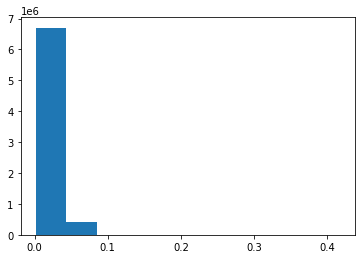

RCE: 4.975608521034214
AP: 0.04118574579651155
Feature importance by 'gain':


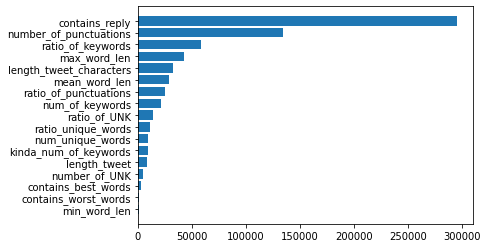




retweet_timestamp model
Mean of the predictions: 0.08107525591947742
Std of the predictions: 0.058731354270224204
Histogram of the predictions:


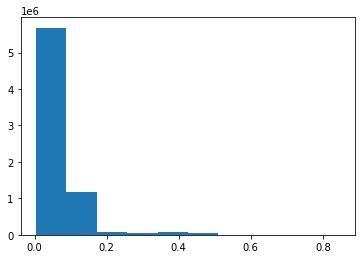

RCE: 5.9755353766602015
AP: 0.18967488976612548
Feature importance by 'gain':


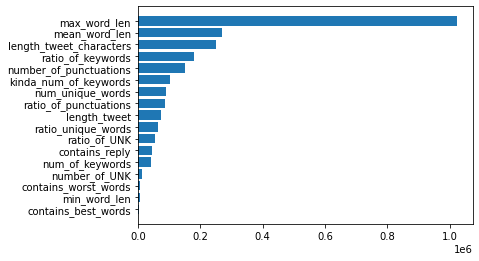




quote_timestamp model
Mean of the predictions: 0.005553009378848819
Std of the predictions: 0.0021906159992100007
Histogram of the predictions:


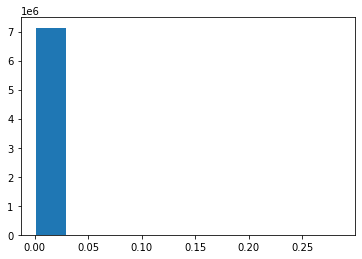

RCE: 1.1683485125522641
AP: 0.008519285465361803
Feature importance by 'gain':


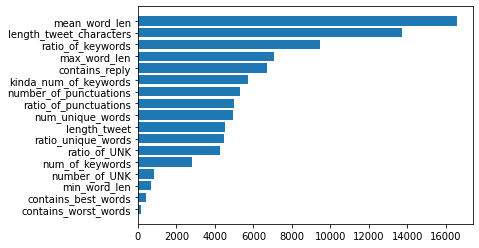




like_timestamp model
Mean of the predictions: 0.4043237599932002
Std of the predictions: 0.1476811581510651
Histogram of the predictions:


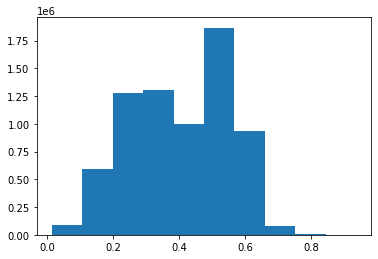

RCE: 7.277164912145628
AP: 0.5572406577554099
Feature importance by 'gain':


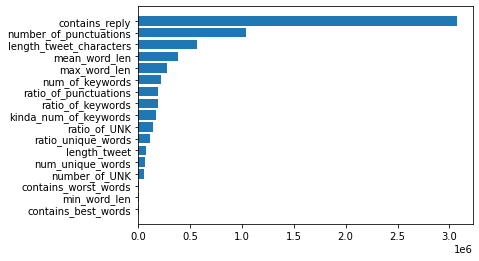

In [17]:
# new data without TFIDF

for target, model in zip(target_columns, models):
    print(target, "model")
    print("="*45)
    evaluate_model(model, test, target, train_columns)
    print("\n"*2)

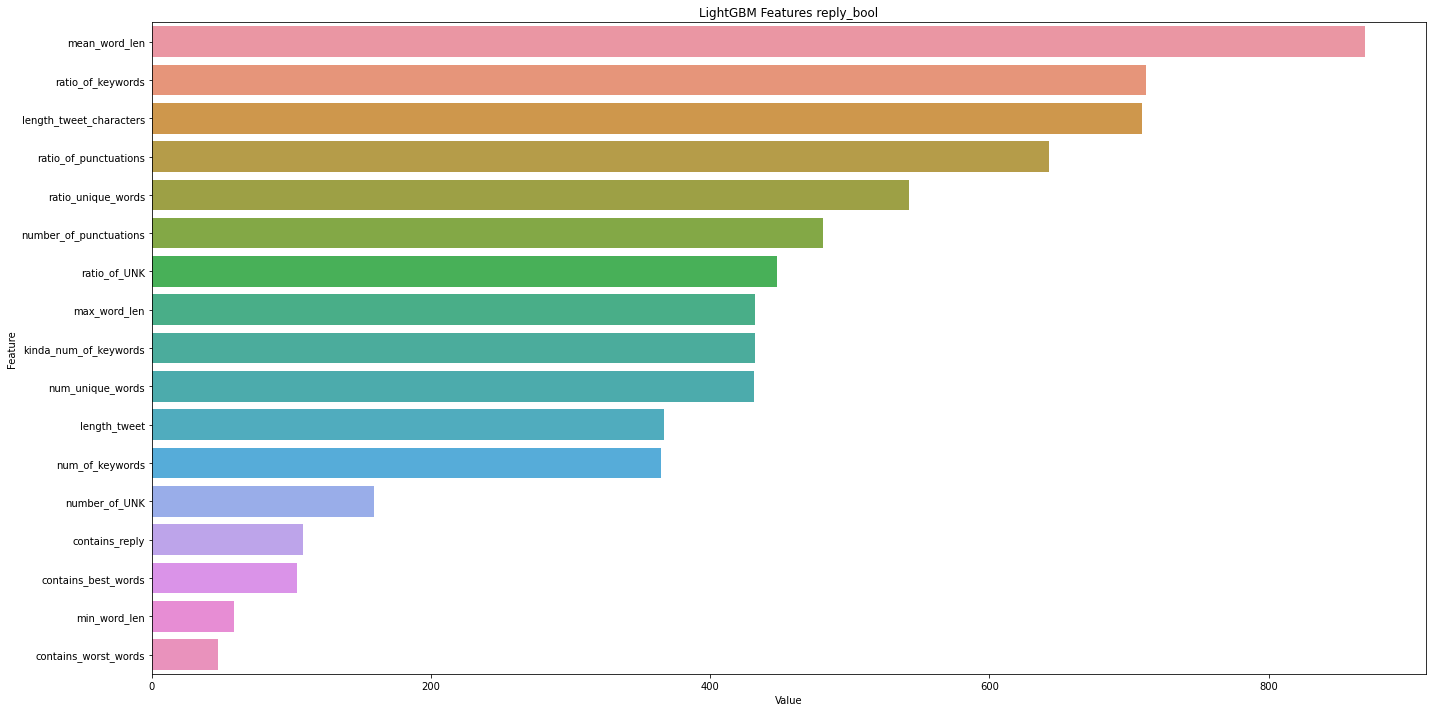

<Figure size 432x288 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(models[0].feature_importance(),train_columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features reply_bool')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

## Feature importance

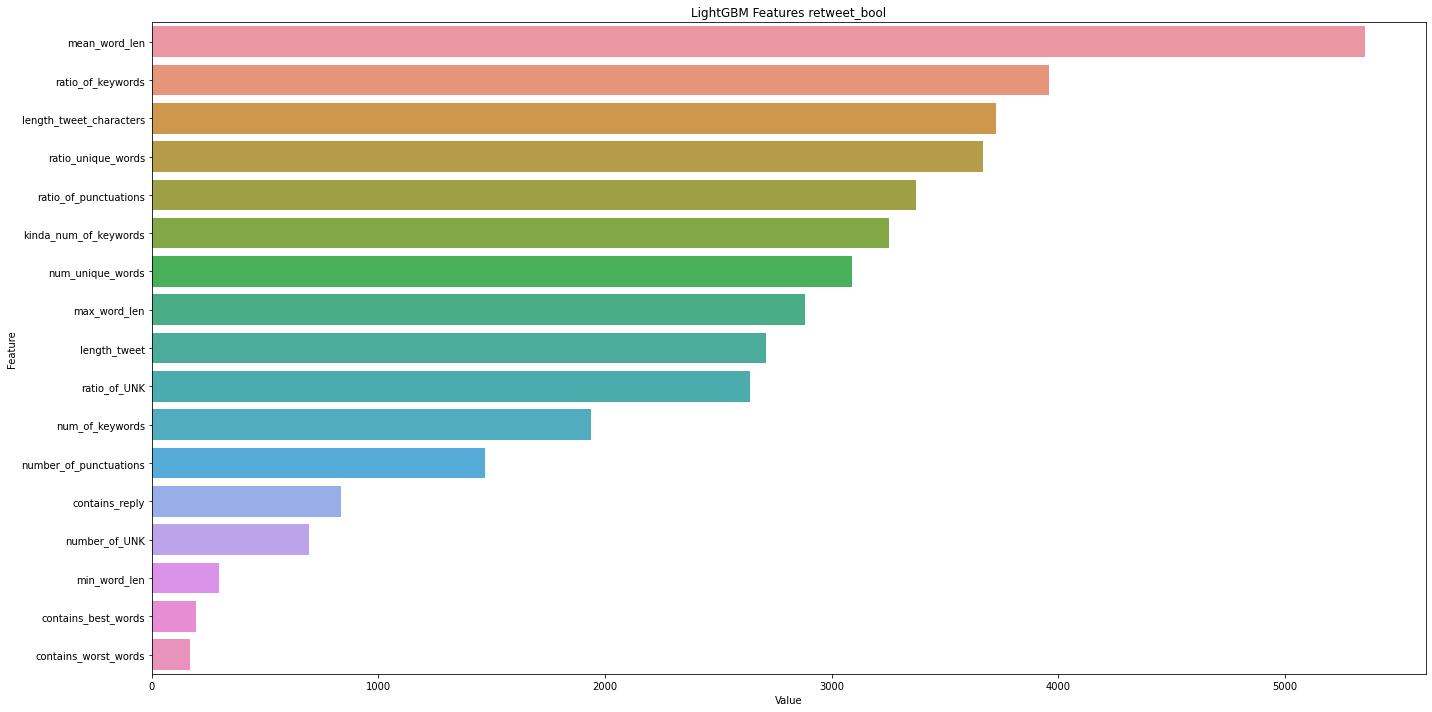

<Figure size 432x288 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(models[1].feature_importance(),train_columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features retweet_bool')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

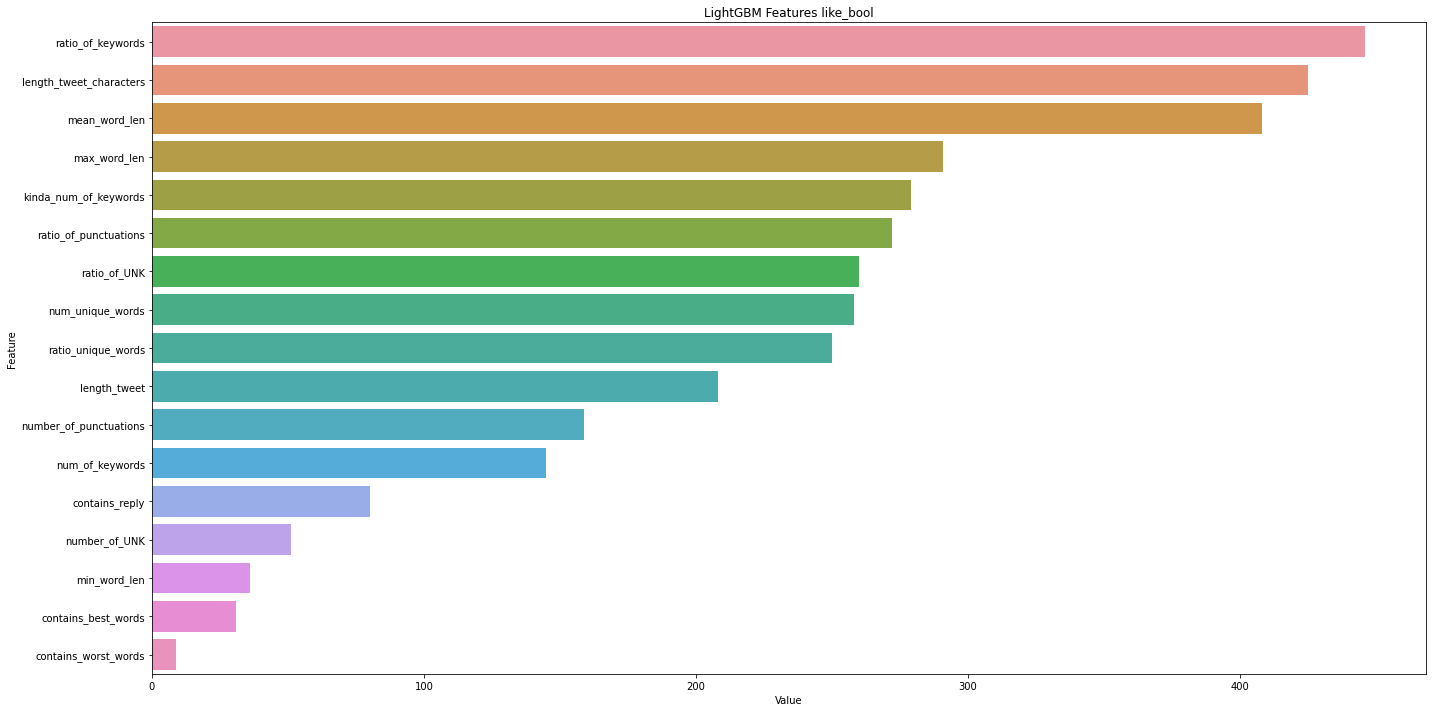

<Figure size 432x288 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(models[2].feature_importance(),train_columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features like_bool')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

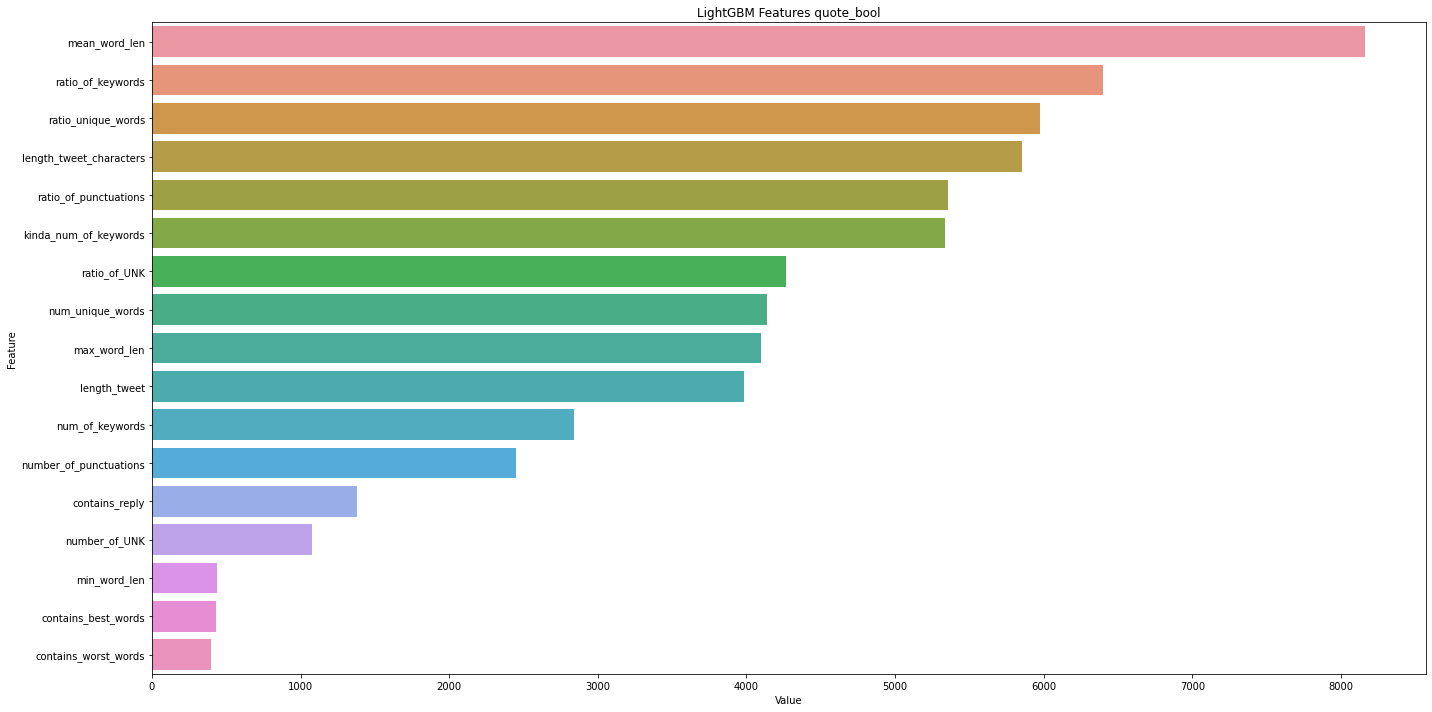

<Figure size 432x288 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(models[3].feature_importance(),train_columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features quote_bool')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

# Save trained models

In [34]:
for target, model in zip(target_columns, models):
    save_model(model, "Text_Model_"+target.split('_')[0]+".mod")

---